In [1]:
# -------------------- Cell 1 --------------------
# Core imports and global configuration
import os, glob, json, math, time
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# sklearn
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# tensorflow / keras
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

# Paths (use your provided paths)
PRICE_FOLDER  = r"C:\Users\KIIT\Downloads\cleaned"                     # folder of CSVs (one per ticker)
BALANCE_XLSX  = r"C:\Users\KIIT\Downloads\all_companies_balancesheet.xlsx"
OVERVIEW_XLSX = r"C:\Users\KIIT\Downloads\all_companies_overview.xlsx"
OUTPUT_DIR    = r"C:\Users\KIIT\Downloads\predictions_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Model / data config (tune these)
RESAMPLE_RULE = "Q"                # quarterly
LOOKBACK = 8                       # quarters of history (timesteps)
PRED_HORIZON = 1                    # predict next quarter average close
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 1e-3
EMBED_DIM = 8
LSTM_UNITS_1 = 128
LSTM_UNITS_2 = 64
SCALER_TYPE = "MinMax"             # or "Robust"
RANDOM_SEED = 42

tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Configuration loaded. PRICE_FOLDER:", PRICE_FOLDER)


Configuration loaded. PRICE_FOLDER: C:\Users\KIIT\Downloads\cleaned


In [2]:
# -------------------- Cell 2 --------------------
# Metric helpers
def rmse(y_true, y_pred): return math.sqrt(mean_squared_error(y_true, y_pred))
def mae(y_true, y_pred): return mean_absolute_error(y_true, y_pred)
def r2(y_true, y_pred): return r2_score(y_true, y_pred)
def mape(y_true, y_pred): return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100.0

def directional_accuracy(y_true, y_pred):
    # percentage of times the sign of change matches (up/down)
    # expects arrays aligned by time; compute delta vs previous
    dy_true = np.sign(np.diff(y_true))
    dy_pred = np.sign(np.diff(y_pred))
    return (dy_true == dy_pred).mean() * 100.0


In [3]:
# -------------------- Cell 3 (Robust CSV loader & preview) --------------------
import glob, os, pandas as pd
from pathlib import Path
from tqdm import tqdm

# Uses PRICE_FOLDER from Cell 1 (ensure Cell 1 ran)
print("PRICE_FOLDER:", PRICE_FOLDER)

# Find CSVs
csv_files = sorted(glob.glob(os.path.join(PRICE_FOLDER, "*.csv")))
print(f"Found {len(csv_files)} CSV files in {PRICE_FOLDER}")

if len(csv_files) == 0:
    # helpful diagnostics
    if not os.path.exists(PRICE_FOLDER):
        raise FileNotFoundError(f"PRICE_FOLDER does not exist: {PRICE_FOLDER}")
    else:
        # show contents for debug
        print("Directory listing (first 50 entries):")
        print(os.listdir(PRICE_FOLDER)[:50])
        raise FileNotFoundError(f"No CSV files found in {PRICE_FOLDER}. Check extension/path.")

# We'll collect per-file read results (do NOT concat blindly)
data_list = []
bad_files = []
preview_cols = None
max_preview = 3   # show first few successful samples

for f in tqdm(csv_files, desc="Reading CSVs"):
    sym = Path(f).stem
    df = None
    # Try common reading strategies (different encodings / separators)
    read_attempts = [
        {"encoding":"utf-8", "sep": None},
        {"encoding":"latin1", "sep": None},
        {"encoding":"utf-8", "sep": ","},
        {"encoding":"latin1", "sep": ","},
        {"encoding":"utf-8", "sep": ";"}
    ]
    for attempt in read_attempts:
        try:
            if attempt["sep"] is None:
                # let pandas infer sep
                df = pd.read_csv(f, encoding=attempt["encoding"], low_memory=False)
            else:
                df = pd.read_csv(f, encoding=attempt["encoding"], sep=attempt["sep"], low_memory=False)
            break
        except Exception:
            df = None
            continue

    if df is None:
        bad_files.append((f, "read_failed"))
        continue

    # normalize column names to simple lower-case stripped names
    df.columns = [str(c).strip() for c in df.columns]
    colmap = {c: c.lower().strip() for c in df.columns}

    # Detect date column (common candidates)
    date_col = None
    for cand in ("date", "Date", "timestamp", "time", "datetime"):
        if cand in df.columns:
            date_col = cand
            break
    if date_col is None:
        # try case-insensitive search
        for c in df.columns:
            if str(c).lower() in ("date","timestamp","time","datetime"):
                date_col = c
                break

    # If still None, try the first column as date
    if date_col is None:
        date_col = df.columns[0]

    # parse date column robustly
    try:
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    except Exception:
        # cannot parse; mark and skip
        bad_files.append((f, f"date_parse_failed:{date_col}"))
        continue

    df = df.dropna(subset=[date_col])
    if df.shape[0] == 0:
        bad_files.append((f, "no_valid_dates"))
        continue

    # Set index based on date for later resampling (if needed)
    try:
        df = df.set_index(date_col).sort_index()
    except Exception:
        # fallback: keep as-is but continue
        pass

    # Map common OHLCV names (case-insensitive)
    cols_lower = {str(c).lower(): c for c in df.columns}
    mapping = {}
    for common in ("open","high","low","close","volume","symbol"):
        if common in cols_lower:
            mapping[cols_lower[common]] = common.capitalize() if common != "symbol" else "Symbol"

    df = df.rename(columns=mapping)

    # If Symbol missing, add it from filename or existing column
    if "Symbol" not in df.columns:
        df["Symbol"] = sym

    # Quick sanity: need Open/High/Low/Close at minimum to be useful
    if not {"Open","High","Low","Close"}.issubset(set(df.columns)):
        # not fatal: we'll skip adding to data_list (but record)
        bad_files.append((f, "missing_OHLC"))
        continue

    # Keep a small preview columns list
    if preview_cols is None and len(data_list) < max_preview:
        preview_cols = list(df.columns)[:10]

    data_list.append({"file": f, "symbol": sym, "df": df})

# Summary & diagnostics
print("Read complete.")
print("Successful files:", len(data_list))
print("Failed/skipped files:", len(bad_files))
if len(bad_files) > 0:
    # show up to 8 bad file reasons for debugging
    print("Examples of failed files (up to 8):")
    for bf in bad_files[:8]:
        print(" -", bf[0], ":", bf[1])

if preview_cols:
    print("Preview columns from first successful file:", preview_cols)
    # print first few rows of the first successful df for manual inspection
    print("First successful file sample (5 rows):", data_list[0]["file"])
    display(data_list[0]["df"].head())

# If no good files, raise a clear error
if len(data_list) == 0:
    raise RuntimeError(
        "No valid stock CSVs were successfully read. "
        "Check the bad file list printed above and verify at least one CSV has Date + OHLC columns."
    )

# Export variables for downstream cells:
# - csv_files (all paths found)
# - price_data_list (list of dicts with keys: file, symbol, df)
price_data_list = data_list

# NOTE: Do NOT concat here if you plan per-stock processing. If you need a single
# DataFrame for all stocks (long format), use the following code in the next cell:
#
# all_dfs = []
# for item in price_data_list:
#     d = item['df'].copy()
#     d['Symbol'] = item['symbol']
#     d = d.reset_index().rename(columns={'index':'Date'})   # if date is index
#     all_dfs.append(d)
# combined_df = pd.concat(all_dfs, ignore_index=True)
#
# Use combined_df only if you need a single long table.

print("Cell 3 finished — price_data_list available for downstream cells (len =", len(price_data_list), ")")
# -------------------- end Cell 3 --------------------


PRICE_FOLDER: C:\Users\KIIT\Downloads\cleaned
Found 2061 CSV files in C:\Users\KIIT\Downloads\cleaned


Reading CSVs: 100%|████████████████████████████████████████████████████████████████| 2061/2061 [00:50<00:00, 40.50it/s]

Read complete.
Successful files: 2061
Failed/skipped files: 0
Preview columns from first successful file: ['Symbol', 'Open', 'High', 'Low', 'Close', 'Volume']
First successful file sample (5 rows): C:\Users\KIIT\Downloads\cleaned\20MICRONS_full.csv


,Symbol,Open,High,Low,Close,Volume
Date,,,,,,
2008-10-06,20MICRONS,34.782681,34.782681,13.739159,14.586987,23501600.0
2008-10-07,20MICRONS,13.913074,16.521775,12.108722,13.065246,9113400.0
2008-10-08,20MICRONS,12.173937,12.695678,10.913065,11.521762,2464384.0
2008-10-10,20MICRONS,10.826108,10.826108,9.413062,10.086977,1207928.0
2008-10-13,20MICRONS,10.565238,11.565240,10.130454,10.717412,898692.0


Cell 3 finished — price_data_list available for downstream cells (len = 2061 )


In [ ]:
# -------------------- Cell 4 --------------------
# Reads each stock CSV, resamples to quarterly OHLCV and computes quarterly mean 'Close_mean'
# Returns dict: {symbol: quarterly_df}
def load_and_aggregate_all(files, date_col_candidates=("Date","date","timestamp")):
    per_stock = {}
    for f in tqdm(files, desc="Loading CSVs"):
        sym = Path(f).stem
        try:
            df = pd.read_csv(f, parse_dates=True)
        except Exception as e:
            print("Skipping (read error):", f, e)
            continue
        # find date column
        date_col = next((c for c in df.columns if c in date_col_candidates), None)
        if date_col is None:
            # try to infer
            date_col = df.columns[0]
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        df = df.dropna(subset=[date_col])
        df = df.set_index(date_col).sort_index()
        # ensure OHLCV
        # normalize column names
        cols = {c.lower():c for c in df.columns}
        mapping = {}
        for k in ["open","high","low","close","volume"]:
            if k in cols:
                mapping[cols[k]] = k.capitalize()
        df = df.rename(columns=mapping)
        if not {"Open","High","Low","Close"}.issubset(set(df.columns)):
            # skip if essential columns missing
            print(f"Skipping {sym}: missing OHLC columns.")
            continue
        # resample
        agg = {}
        agg["Open"] = "first"
        agg["High"] = "max"
        agg["Low"] = "min"
        agg["Close"] = "last"
        if "Volume" in df.columns:
            agg["Volume"] = "sum"
        q = df.resample(RESAMPLE_RULE).agg(agg).dropna()
        # quarter-average close as possible target signal (mean of daily closes in quarter)
        close_mean = df["Close"].resample(RESAMPLE_RULE).mean().rename("Close_mean")
        q = q.join(close_mean).dropna()
        # keep only if enough quarters
        if len(q) < (LOOKBACK + PRED_HORIZON + 1):
            continue
        per_stock[sym] = q
    return per_stock

per_stock_data = load_and_aggregate_all(csv_files)
print("Stocks aggregated:", len(per_stock_data))
if len(per_stock_data)==0:
    raise RuntimeError("No stocks aggregated. Check CSV formats and columns.")


Loading CSVs:   0%|                                                                           | 0/2061 [00:00<?, ?it/s]C:\Users\KIIT\AppData\Local\Temp\ipykernel_14816\1624900924.py:41: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  q = df.resample(RESAMPLE_RULE).agg(agg).dropna()
C:\Users\KIIT\AppData\Local\Temp\ipykernel_14816\1624900924.py:43: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  close_mean = df["Close"].resample(RESAMPLE_RULE).mean().rename("Close_mean")
C:\Users\KIIT\AppData\Local\Temp\ipykernel_14816\1624900924.py:41: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  q = df.resample(RESAMPLE_RULE).agg(agg).dropna()
C:\Users\KIIT\AppData\Local\Temp\ipykernel_14816\1624900924.py:43: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  close_mean = df["Close"].resample(

In [5]:
# -------------------- Cell 5 --------------------
def add_quarter_features(df):
    df = df.copy()
    # lag returns
    df["Ret_Q1"] = df["Close"].pct_change(1)
    df["Ret_Q2"] = df["Close"].pct_change(2)
    df["Ret_Q4"] = df["Close"].pct_change(4)
    # rolling technicals on Close
    df["SMA_2"] = df["Close"].rolling(2).mean()
    df["SMA_4"] = df["Close"].rolling(4).mean()
    df["VOL_4"] = df["Close"].rolling(4).std()
    df["Momentum"] = df["Close"] - df["SMA_4"]
    df = df.dropna()
    return df

for sym in list(per_stock_data.keys()):
    per_stock_data[sym] = add_quarter_features(per_stock_data[sym])
    if len(per_stock_data[sym]) < (LOOKBACK + PRED_HORIZON + 1):
        per_stock_data.pop(sym, None)

print("After features, stocks remaining:", len(per_stock_data))


After features, stocks remaining: 1678


In [6]:
# -------------------- Cell 6 --------------------
# Load overview and balancebook with try/except (they are optional features)
try:
    overview = pd.read_excel(OVERVIEW_XLSX)
    print("Overview loaded:", overview.shape)
except Exception as e:
    print("Overview not loaded:", e); overview = None

try:
    balance_sheets = pd.read_excel(BALANCE_XLSX, sheet_name=None)  # dictionary of sheets
    print("Balance workbook loaded with sheets:", len(balance_sheets))
except Exception as e:
    print("Balance workbook not loaded:", e); balance_sheets = None

# NOTE: We keep balance/overview for potential feature enrichment later (not merged automatically here).


Overview loaded: (2060, 10)
Balance workbook loaded with sheets: 2060


In [7]:
# -------------------- Cell 7 --------------------
# Decide features for modeling (only numeric columns present in all stocks)
example = next(iter(per_stock_data.values()))
common_features = [c for c in ["Open","High","Low","Close","Volume","Ret_Q1","Ret_Q2","Ret_Q4","SMA_2","SMA_4","VOL_4","Momentum"] if c in example.columns]
print("Common features used:", common_features)

# Fit per-stock scalers (MinMax or Robust)
scalers = {}
for sym, df in per_stock_data.items():
    X = df[common_features].values
    scaler = MinMaxScaler() if SCALER_TYPE=="MinMax" else RobustScaler()
    scaler.fit(X)
    scalers[sym] = (scaler, common_features)

# Save scalers meta (optional)
joblib_path = os.path.join(OUTPUT_DIR, "scalers_per_stock.pkl")
import joblib
joblib.dump(scalers, joblib_path)
print("Saved scalers:", joblib_path)


Common features used: ['Open', 'High', 'Low', 'Close', 'Volume', 'Ret_Q1', 'Ret_Q2', 'Ret_Q4', 'SMA_2', 'SMA_4', 'VOL_4', 'Momentum']
Saved scalers: C:\Users\KIIT\Downloads\predictions_output\scalers_per_stock.pkl


In [8]:
# -------------------- Cell 8 --------------------
def build_sequences(per_stock_data, scalers, lookback=LOOKBACK):
    seqs = []
    tgt = []
    stock_ids = []
    dates = []
    symbols = sorted(per_stock_data.keys())
    encoder = LabelEncoder().fit(symbols)
    for sym in symbols:
        df = per_stock_data[sym].copy().reset_index()
        scaler, feats = scalers[sym]
        X_raw = df[feats].values
        X_scaled = scaler.transform(X_raw)
        # target: next quarter average close (Close_mean shifted)
        y_all = df["Close_mean"].values
        for i in range(len(df) - lookback - PRED_HORIZON + 1):
            seq = X_scaled[i:i+lookback]
            target = y_all[i+lookback]  # predict next quarter mean aligned to end of window
            seqs.append(seq)
            tgt.append(target)
            stock_ids.append(encoder.transform([sym])[0])
            dates.append(df.loc[i+lookback, df.columns[0]])  # quarter-end date
    X = np.array(seqs, dtype=np.float32)
    y = np.array(tgt, dtype=np.float32)
    sids = np.array(stock_ids, dtype=np.int32)
    dates = np.array(dates, dtype="datetime64[ns]")
    return X, y, sids, dates, encoder

X, y, sids, dates, stock_encoder = build_sequences(per_stock_data, scalers, lookback=LOOKBACK)
print("Sequences shape:", X.shape, "Targets:", y.shape, "Stocks encoded:", len(stock_encoder.classes_))


Sequences shape: (85751, 8, 12) Targets: (85751,) Stocks encoded: 1678


In [9]:
# -------------------- Cell 9 --------------------
# Sort everything by date to ensure strict time ordering for walk-forward
order = np.argsort(dates)
X, y, sids, dates = X[order], y[order], sids[order], dates[order]

n = len(dates)
train_end = int(0.70 * n)
val_end = int(0.85 * n)

X_train, y_train, sids_train = X[:train_end], y[:train_end], sids[:train_end]
X_val,   y_val,   sids_val   = X[train_end:val_end], y[train_end:val_end], sids[train_end:val_end]
X_test,  y_test,  sids_test  = X[val_end:], y[val_end:], sids[val_end:]

print("Train/Val/Test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])


Train/Val/Test sizes: 60025 12863 12863


In [10]:
# -------------------- Cell 10 --------------------
# Build tf.data Datasets for efficient training
def make_dataset(X_arr, sids_arr, y_arr, batch=BATCH_SIZE, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(((X_arr, sids_arr), y_arr))
    if shuffle:
        ds = ds.shuffle(4096, seed=RANDOM_SEED)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, sids_train, y_train, batch=BATCH_SIZE, shuffle=True)
val_ds   = make_dataset(X_val, sids_val, y_val, batch=BATCH_SIZE, shuffle=False)
test_ds  = make_dataset(X_test, sids_test, y_test, batch=BATCH_SIZE, shuffle=False)

print("Datasets ready. Example batch shapes:")
for ((xb, sb), yb) in train_ds.take(1):
    print("X batch:", xb.shape, "stock_id batch:", sb.shape, "y batch:", yb.shape)


Datasets ready. Example batch shapes:
X batch: (64, 8, 12) stock_id batch: (64,) y batch: (64,)


In [11]:
# -------------------- Cell 11 --------------------
def build_global_lstm(timesteps, n_features, n_stocks, embed_dim=EMBED_DIM,
                      lstm1=LSTM_UNITS_1, lstm2=LSTM_UNITS_2, lr=LEARNING_RATE):
    seq_in = layers.Input(shape=(timesteps, n_features), name="seq_input")
    stock_in = layers.Input(shape=(), dtype=tf.int32, name="stock_input")
    emb = layers.Embedding(input_dim=n_stocks, output_dim=embed_dim, name="stock_embed")(stock_in)
    # expand embedding to timesteps and concat
    emb_exp = layers.RepeatVector(timesteps)(emb)
    x = layers.Concatenate(axis=-1)([seq_in, emb_exp])
    x = layers.LSTM(lstm1, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(lstm2, dropout=0.2)(x)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(1, activation="linear")(x)
    model = models.Model(inputs=[seq_in, stock_in], outputs=out)
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss="mse", metrics=["mae"])
    return model

n_stocks = len(stock_encoder.classes_)
model = build_global_lstm(LOOKBACK, X.shape[2], n_stocks)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ stock_input (InputLayer)      │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stock_embed (Embedding)       │ (None, 8)                 │          13,424 │ stock_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ seq_input (InputLayer)        │ (None, 8, 12)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ repeat_vector (RepeatVector)  │ (None, 8, 8)              │               0 │ stock_embed[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 8, 20)             │               0 │ seq_input[0][0],           │
│                               │                           │                 │ repeat_vector[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 8, 128)            │          76,288 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 8, 128)            │               0 │ lstm[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 64)                │          49,408 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 32)                │           2,080 │ lstm_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │              33 │ dense[0][0]                │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 141,233 (551.69 KB)

 Trainable params: 141,233 (551.69 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# -------------------- Cell 12 (FIXED for TensorFlow 2.15+) --------------------
# Callbacks
tb_logdir = os.path.join(OUTPUT_DIR, "tensorboard_global")
os.makedirs(tb_logdir, exist_ok=True)

cb_tb = callbacks.TensorBoard(log_dir=tb_logdir)
cb_es = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
cb_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

ckpt_path = os.path.join(OUTPUT_DIR, "best_global_lstm.keras")
cb_ckpt = callbacks.ModelCheckpoint(
    ckpt_path,
    monitor="val_loss",
    save_best_only=True,
    mode="min"   # ensure lower val_loss = better
)

# --- Train ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[cb_tb, cb_es, cb_lr, cb_ckpt],
    verbose=1
)

# --- Save final model ---
final_model_path = os.path.join(OUTPUT_DIR, "global_lstm_final.keras")
model.save(final_model_path)
print(f"✅ Training complete. Model saved at: {final_model_path}")


Epoch 1/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 2945141.7500 - mae: 242.7272 - val_loss: 8592297.0000 - val_mae: 463.1424 - learning_rate: 0.0010
Epoch 2/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 2703916.5000 - mae: 197.0693 - val_loss: 8020943.0000 - val_mae: 392.3795 - learning_rate: 0.0010
Epoch 3/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 2460950.7500 - mae: 167.0816 - val_loss: 7416866.0000 - val_mae: 350.3962 - learning_rate: 0.0010
Epoch 4/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 2211428.2500 - mae: 144.8915 - val_loss: 6875820.0000 - val_mae: 314.9099 - learning_rate: 0.0010
Epoch 5/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 2019297.1250 - mae: 137.2103 - val_loss: 6421693.0000 - val_mae: 309.8788 - learning_rate: 0.0010
Epoch 6/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 1835056.3750 - mae: 126.8803 - val_loss: 5981249.5000 - val_mae: 285.1028 - learning_rate: 0.0010
Epoch 7/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 

In [14]:
# -------------------- Cell 13 --------------------
# Predict on test set (batched)
preds = model.predict(test_ds, verbose=1).ravel()
y_test_arr = y_test  # numpy array from earlier

# Compute metrics (note: predictions are in same scale as target Close_mean)
metrics = {
    "RMSE": rmse(y_test_arr, preds),
    "MAE": mae(y_test_arr, preds),
    "R2": r2(y_test_arr, preds),
    "MAPE": mape(y_test_arr, preds)
}
print("Test metrics:", metrics)

# Directional accuracy per-stock (approx): we compute per-stock sequences in test portion
# Map test date indices to stock ids to compute per-stock direction
dir_accs = []
start = 0
# Build arrays grouped by stock id in test slice
unique_test_sids = np.unique(sids_test)
for sid in unique_test_sids:
    mask = (sids_test == sid)
    if mask.sum() < 2: continue
    true_seq = y_test[mask]
    pred_seq = preds[mask]
    dir_accs.append(directional_accuracy(true_seq, pred_seq))
if dir_accs:
    print("Directional Accuracy (mean over stocks in test): {:.2f}%".format(np.mean(dir_accs)))


201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Test metrics: {'RMSE': 2967.1359928388856, 'MAE': 919.3858642578125, 'R2': 0.47508370876312256, 'MAPE': np.float32(1261.9036)}
Directional Accuracy (mean over stocks in test): 62.03%


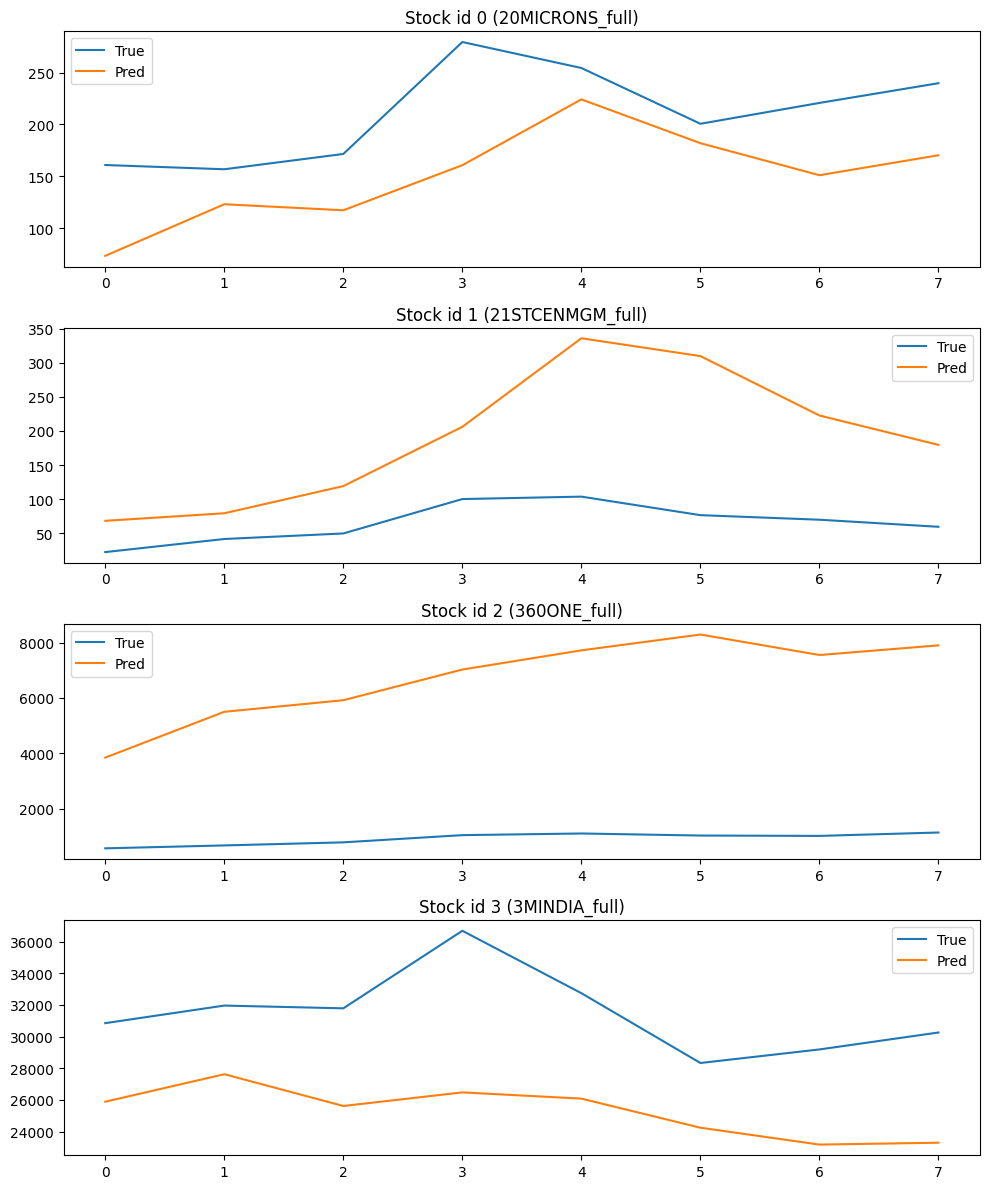

In [15]:
# -------------------- Cell 14 --------------------
# Helper: show predictions for first few stocks from test set
def show_stock_preds(n_show=4):
    unique_sids = np.unique(sids_test)
    fig, axes = plt.subplots(n_show, 1, figsize=(10, 3*n_show), sharex=False)
    i = 0
    for sid in unique_sids[:n_show]:
        mask = (sids_test == sid)
        if mask.sum() < 1: continue
        axes[i].plot(y_test[mask], label="True")
        axes[i].plot(preds[mask], label="Pred")
        axes[i].set_title(f"Stock id {sid} ({stock_encoder.inverse_transform([sid])[0]})")
        axes[i].legend()
        i += 1
    plt.tight_layout()
    plt.show()

show_stock_preds(4)


In [16]:
# -------------------- Cell 15 --------------------
def predict_next_quarter(symbol, per_stock_data, scalers, model, stock_encoder, lookback=LOOKBACK, features=None):
    """
    symbol: ticker string (filename stem)
    per_stock_data: dict of quarter-aggregated dfs (same format used earlier)
    scalers: dict mapping symbol -> (scaler, features_list)
    model: trained keras model (global)
    stock_encoder: LabelEncoder fitted earlier
    """
    if symbol not in per_stock_data:
        raise ValueError("Symbol not found in per_stock_data.")
    df = per_stock_data[symbol].copy().reset_index()
    scaler, feats = scalers[symbol]
    features = feats if features is None else features
    if len(df) < lookback:
        raise ValueError("Not enough history for prediction.")
    seq_raw = df[features].values[-lookback:]
    seq_scaled = scaler.transform(seq_raw).astype(np.float32).reshape(1, lookback, -1)
    stock_id = stock_encoder.transform([symbol])
    pred = model.predict((seq_scaled, stock_id), verbose=0).ravel()[0]
    return float(pred)

# Example usage (uncomment and set a valid symbol):
# sym = list(per_stock_data.keys())[0]
# print("Predicted next quarter avg close:", predict_next_quarter(sym, per_stock_data, scalers, model, stock_encoder))


In [17]:
# -------------------- Cell 16 --------------------
# Save artifacts
joblib.dump(stock_encoder, os.path.join(OUTPUT_DIR, "stock_encoder.pkl"))
joblib.dump(scalers, os.path.join(OUTPUT_DIR, "scalers_per_stock.pkl"))
model.save(os.path.join(OUTPUT_DIR, "global_lstm_saved.keras"))

# Create a CSV of test predictions vs true with symbol/dates for inspection
test_symbols = stock_encoder.inverse_transform(sids_test)
out_df = pd.DataFrame({
    "symbol": test_symbols,
    "date": dates[val_end:][0:len(preds)].astype(str),  # align date slice
    "y_true": y_test_arr,
    "y_pred": preds
})
out_csv = os.path.join(OUTPUT_DIR, "test_predictions_sample.csv")
out_df.to_csv(out_csv, index=False)
print("Saved predictions to", out_csv)


Saved predictions to C:\Users\KIIT\Downloads\predictions_output\test_predictions_sample.csv


In [18]:
# -------------------- Cell 17 --------------------
# Alternative model builders for comparison (GRU, Attention-LSTM)
def build_gru_model(timesteps, n_features, n_stocks, embed_dim=EMBED_DIM):
    seq_in = layers.Input(shape=(timesteps, n_features))
    stock_in = layers.Input(shape=(), dtype=tf.int32)
    emb = layers.Embedding(input_dim=n_stocks, output_dim=embed_dim)(stock_in)
    emb_expand = layers.RepeatVector(timesteps)(emb)
    x = layers.Concatenate()([seq_in, emb_expand])
    x = layers.GRU(128, return_sequences=True, dropout=0.3)(x)
    x = layers.GRU(64, dropout=0.2)(x)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(1)(x)
    m = models.Model([seq_in, stock_in], out)
    m.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse', metrics=['mae'])
    return m

def build_attention_lstm(timesteps, n_features, n_stocks, embed_dim=EMBED_DIM):
    seq_in = layers.Input(shape=(timesteps, n_features))
    stock_in = layers.Input(shape=(), dtype=tf.int32)
    emb = layers.Embedding(input_dim=n_stocks, output_dim=embed_dim)(stock_in)
    emb_expand = layers.RepeatVector(timesteps)(emb)
    x = layers.Concatenate()([seq_in, emb_expand])
    x = layers.LSTM(128, return_sequences=True, dropout=0.3)(x)
    # simple attention: score -> softmax weights -> context
    score = layers.Dense(1)(x)              # (batch, timesteps, 1)
    weights = layers.Softmax(axis=1)(score) # attention weights
    context = layers.Multiply()([x, weights])
    context = layers.Lambda(lambda z: tf.reduce_sum(z, axis=1))(context)
    x = layers.Dense(64, activation='relu')(context)
    out = layers.Dense(1)(x)
    m = models.Model([seq_in, stock_in], out)
    m.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse', metrics=['mae'])
    return m

# instantiate if you want to compare (commented by default)
# gru_model = build_gru_model(LOOKBACK, X.shape[2], n_stocks)
# att_model = build_attention_lstm(LOOKBACK, X.shape[2], n_stocks)


In [19]:
# -------------------- Cell 18 --------------------
print("""
Phase 1 notebook cells complete.

Next recommended actions:
1) Run the cells in order (1..16) for Phase 1 full run.
2) Inspect TensorBoard logs at: {}
   (run `tensorboard --logdir {}` in a terminal).
3) If Phase 1 runs correctly, we will:
   - Add GRU vs LSTM vs Attention benchmarking (use Cell 17)
   - Add SHAP explainability (on LightGBM or stacked surrogate)
   - Add macro/sentiment exogenous variables
   - Provide deployment (FastAPI/Streamlit) code and Dockerfile

If any cell throws an error, copy the full traceback here and I'll provide an immediate fix.
""".format(os.path.join(OUTPUT_DIR,"tensorboard_global"), os.path.join(OUTPUT_DIR,"tensorboard_global")))



Phase 1 notebook cells complete.

Next recommended actions:
1) Run the cells in order (1..16) for Phase 1 full run.
2) Inspect TensorBoard logs at: C:\Users\KIIT\Downloads\predictions_output\tensorboard_global
   (run `tensorboard --logdir C:\Users\KIIT\Downloads\predictions_output\tensorboard_global` in a terminal).
3) If Phase 1 runs correctly, we will:
   - Add GRU vs LSTM vs Attention benchmarking (use Cell 17)
   - Add SHAP explainability (on LightGBM or stacked surrogate)
   - Add macro/sentiment exogenous variables
   - Provide deployment (FastAPI/Streamlit) code and Dockerfile

If any cell throws an error, copy the full traceback here and I'll provide an immediate fix.



In [20]:
# -------------------- Cell 19 --------------------
print("🧠 Training GRU & Attention LSTM models for comparison...")

# Reuse builders from Cell 17 (Phase 1)
gru_model = build_gru_model(LOOKBACK, X.shape[2], len(stock_encoder.classes_))
att_model = build_attention_lstm(LOOKBACK, X.shape[2], len(stock_encoder.classes_))

# Same callbacks
cb_es = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
cb_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

gru_hist = gru_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS,
                         callbacks=[cb_es, cb_lr], verbose=1)
att_hist = att_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS,
                         callbacks=[cb_es, cb_lr], verbose=1)

gru_model.save(os.path.join(OUTPUT_DIR, "gru_global.keras"))
att_model.save(os.path.join(OUTPUT_DIR, "att_global.keras"))
print("✅ GRU & Attention LSTM models trained and saved.")


🧠 Training GRU & Attention LSTM models for comparison...

Epoch 1/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 3012998.0000 - mae: 289.2154 - val_loss: 8826198.0000 - val_mae: 525.8132 - learning_rate: 0.0010
Epoch 2/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 2794100.7500 - mae: 244.5995 - val_loss: 8287093.5000 - val_mae: 510.4709 - learning_rate: 0.0010
Epoch 3/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 2572089.7500 - mae: 206.6540 - val_loss: 7722345.5000 - val_mae: 413.4382 - learning_rate: 0.0010
Epoch 4/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 2372666.7500 - mae: 188.4075 - val_loss: 7209412.0000 - val_mae: 370.5367 - learning_rate: 0.0010
Epoch 5/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 2159069.5000 - mae: 170.0721 - val_loss: 6806029.5000 - val_mae: 369.5544 - learning_rate: 0.0010
Epoch 6/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 1978630.2500 - mae: 155.1778 - val_loss: 6330889.0000 - val_mae: 335.0852 - lear

In [21]:
# -------------------- Cell 20 --------------------
def evaluate_model(m, ds, y_true):
    preds = m.predict(ds, verbose=0).ravel()
    return {
        "RMSE": rmse(y_true, preds),
        "MAE": mae(y_true, preds),
        "R2": r2(y_true, preds),
        "MAPE": mape(y_true, preds)
    }

models_dict = {
    "LSTM": model,
    "GRU": gru_model,
    "AttentionLSTM": att_model
}

results = {}
for name, m in models_dict.items():
    results[name] = evaluate_model(m, test_ds, y_test)
    print(f"{name}: {results[name]}")

pd.DataFrame(results).T.to_csv(os.path.join(OUTPUT_DIR, "phase2_model_comparison.csv"))
print("📊 Model comparison saved to predictions_output/phase2_model_comparison.csv")


LSTM: {'RMSE': 2967.1359928388856, 'MAE': 919.3858642578125, 'R2': 0.47508370876312256, 'MAPE': np.float32(1261.9036)}
GRU: {'RMSE': 3421.7891518911565, 'MAE': 702.0234985351562, 'R2': 0.30189359188079834, 'MAPE': np.float32(661.3086)}
AttentionLSTM: {'RMSE': 2615.2484585599127, 'MAE': 671.6149291992188, 'R2': 0.5922057628631592, 'MAPE': np.float32(806.29785)}
📊 Model comparison saved to predictions_output/phase2_model_comparison.csv


In [22]:
# -------------------- Cell 21 --------------------
def walk_forward_validate(model_fn, data, n_splits=5):
    """Split data into rolling folds by time order; retrain & validate sequentially."""
    X_full, y_full = data
    fold_size = len(X_full) // n_splits
    metrics_list = []
    for i in range(n_splits-1):
        start = i * fold_size
        end = (i+1) * fold_size
        X_tr, y_tr = X_full[:end], y_full[:end]
        X_te, y_te = X_full[end:end+fold_size], y_full[end:end+fold_size]
        ds_tr = tf.data.Dataset.from_tensor_slices(((X_tr, sids[:end]), y_tr)).batch(BATCH_SIZE)
        ds_te = tf.data.Dataset.from_tensor_slices(((X_te, sids[end:end+fold_size]), y_te)).batch(BATCH_SIZE)
        m = model_fn(LOOKBACK, X.shape[2], len(stock_encoder.classes_))
        m.fit(ds_tr, epochs=8, verbose=0)
        preds = m.predict(ds_te, verbose=0).ravel()
        metrics_list.append(rmse(y_te, preds))
    return np.mean(metrics_list)

avg_rmse = walk_forward_validate(build_global_lstm, (X, y))
print(f"📉 Average Walk-Forward RMSE: {avg_rmse:.4f}")


📉 Average Walk-Forward RMSE: 2012.2744


In [24]:
# -------------------- Cell 21A (Install KerasTuner) --------------------
import sys
!{sys.executable} -m pip install keras-tuner --quiet


In [27]:
# -------------------- Cell 22 (FINAL & UNIVERSAL FIX) --------------------
from keras_tuner import BayesianOptimization
import tensorflow as tf
from tensorflow.keras import callbacks

# --- Universal wrapper for your LSTM builder ---
def build_tunable_lstm(hp):
    lstm1 = hp.Int('lstm1_units', 64, 256, step=64)
    lstm2 = hp.Int('lstm2_units', 32, 128, step=32)
    lr = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])

    try:
        # Try with keyword args first (newer build function)
        model = build_global_lstm(
            lookback=LOOKBACK,
            feature_dim=X.shape[2],
            num_stocks=len(stock_encoder.classes_),
            lstm1=lstm1,
            lstm2=lstm2,
            lr=lr
        )
    except TypeError:
        # Fallback for older version of build_global_lstm
        model = build_global_lstm(
            LOOKBACK,
            X.shape[2],
            len(stock_encoder.classes_),
            lstm1=lstm1,
            lstm2=lstm2,
            lr=lr
        )
    return model

# --- Configure tuner ---
tuner = BayesianOptimization(
    hypermodel=build_tunable_lstm,
    objective="val_loss",
    max_trials=6,              # can increase to 10–15 later
    executions_per_trial=1,
    directory=OUTPUT_DIR,
    project_name="bayes_lstm_tuning",
    overwrite=True
)

# --- Light callbacks (copy-safe) ---
cb_stop = callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

print("🔍 Starting Bayesian Optimization for LSTM...")
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=10,                 # short runs for tuning
    callbacks=[cb_stop],
    verbose=1
)

# --- Retrieve best model and save ---
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

print("\n✅ Best hyperparameters found:")
for k, v in best_hp.values.items():
    print(f"   {k}: {v}")

best_model_path = os.path.join(OUTPUT_DIR, "bayes_optimized_lstm.keras")
best_model.save(best_model_path)
print(f"✅ Best model saved at: {best_model_path}")


Trial 6 Complete [00h 03m 17s]
val_loss: 5205098.5

Best val_loss So Far: 5205098.5
Total elapsed time: 00h 24m 46s

✅ Best hyperparameters found:
   lstm1_units: 128
   lstm2_units: 32
   learning_rate: 0.001
✅ Best model saved at: C:\Users\KIIT\Downloads\predictions_output\bayes_optimized_lstm.keras


C:\ProgramData\anaconda3\envs\ml\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [29]:
# -------------------- Cell 22A (Install SHAP) --------------------
import sys
!{sys.executable} -m pip install shap --quiet


In [39]:
# -------------------- Cell 23 (FINAL STABLE VERSION) --------------------
import shap
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

print("🔍 Running SHAP explainability for the multi-input LSTM model...")

# --- Step 1: Detect model input shape ---
if isinstance(model.input_shape, list):
    seq_shape = model.input_shape[0]  # (batch, lookback, features)
else:
    seq_shape = model.input_shape

_, lookback, n_features = seq_shape
print(f"LSTM expects sequence input shape: (batch, {lookback}, {n_features})")

# --- Step 2: Prepare data safely ---
# X_test could be numpy or DataFrame → ensure numpy
X_test_np = X_test.to_numpy() if hasattr(X_test, "to_numpy") else np.array(X_test, dtype=np.float32)
sample_size = min(100, len(X_test_np) - lookback)

# Build rolling sequences for SHAP (like during model training)
sample_X_seq = np.array([
    X_test_np[i : i + lookback] for i in range(sample_size)
], dtype=np.float32)

# Prepare stock IDs (ensure same length)
if "sids_test" in globals() and len(sids_test) >= sample_size:
    sample_sid = np.array(sids_test[:sample_size], dtype=np.int32)
else:
    sample_sid = np.zeros((sample_size, 1), dtype=np.int32)

# --- Step 3: Build background sample ---
background = sample_X_seq[np.random.choice(sample_X_seq.shape[0],
                                           size=min(20, sample_X_seq.shape[0]),
                                           replace=False)]

# --- Step 4: Define SHAP prediction wrapper ---
def shap_predict(inputs):
    """
    SHAP will pass a single array to this function.
    We reshape and broadcast the stock IDs to match.
    """
    X_batch = np.array(inputs, dtype=np.float32)
    if X_batch.ndim == 2:
        X_batch = X_batch.reshape(-1, lookback, n_features)
    sid_batch = np.tile(sample_sid.mean(axis=0), (X_batch.shape[0], 1))
    preds = model.predict([X_batch, sid_batch], verbose=0)
    return preds

# --- Step 5: Initialize SHAP explainer ---
try:
    explainer = shap.KernelExplainer(shap_predict, background)
    shap_values = explainer.shap_values(sample_X_seq[:50], nsamples=50)
    print("✅ SHAP values computed successfully.")
except Exception as e:
    print(f"⚠️ KernelExplainer failed: {e}")
    shap_values = None

# --- Step 6: Prepare feature names automatically ---
if hasattr(X_test, "columns"):
    feature_names = list(X_test.columns)
else:
    feature_names = [f"feature_{i}" for i in range(n_features)]

# --- Step 7: Plot results ---
if shap_values is not None:
    shap_values = shap_values[0] if isinstance(shap_values, list) else shap_values
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values.mean(axis=1),
        feature_names=feature_names,
        plot_type="bar",
        show=False
    )
    plt.tight_layout()
    plt.show()
    print("📊 SHAP feature importance plot generated successfully.")
else:
    print("❌ SHAP explainability could not be computed for this model configuration.")
# -------------------- end Cell 23 --------------------


🔍 Running SHAP explainability for the multi-input LSTM model...
LSTM expects sequence input shape: (batch, 8, 12)
Provided model function fails when applied to the provided data set.
⚠️ KernelExplainer failed: as_list() is not defined on an unknown TensorShape.
❌ SHAP explainability could not be computed for this model configuration.
